# Quizizz User Registration Analysis

### Table of contents
- [Imports](#Imports)
- [Feature Engineering](#Drop-redundant-columns-and-feature-engineering)
- [Data Exploration](#Data-Exploration)
- [Visualization](#Visualization)
- [Conclusion](#Conclusion)

#### Imports

In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_json('data_role_assignment.json', lines=True)
data.head()

,eventId,params,serverTime,version
0,5b33e94a8b5fdc0010f46d92,"[{'key': 'sessionId', 'value': 'NaN-0503143819...",2018-06-27 19:45:14 UTC,A
1,5b33eb518b5fdc0010f4786f,"[{'key': 'sessionId', 'value': 'NaN-0503143819...",2018-06-27 19:53:53 UTC,A
2,5b33e9168b5fdc0010f46c88,"[{'key': 'sessionId', 'value': 'NaN-0503143819...",2018-06-27 19:44:22 UTC,A
3,5b33ec2e8b5fdc0010f47ce1,"[{'key': 'sessionId', 'value': 'NaN-0503143819...",2018-06-27 19:57:34 UTC,A
4,5b33eb48454f270010a084f5,"[{'key': 'sessionId', 'value': 'NaN-0503143819...",2018-06-27 19:53:44 UTC,A


### separating params into columns

In [3]:
def param_cols(row):
    series_obj = {'sessionId':row[0]['value'], 'page': row[1]['value']}
    if 'value' in row[2]:
        series_obj['userId'] = row[2]['value']
    else:
        series_obj['userId'] = np.NaN
    return pd.Series(series_obj)

start_parse = time.time()
data = data.merge(data.params.apply(lambda s: param_cols(s)), left_index=True, right_index=True)
end_parse = time.time()
print('Parsed in {0} seconds'.format(round(end_parse-start_parse),3))

Parsed in 54 seconds


In [4]:
print("{} users registered out of {} events".format(data['userId'].nunique(), len(data)))

13639 users registered out of 107839 events


### Drop redundant columns and feature engineering

In [5]:
data.drop(columns=['params'], inplace=True)

In [6]:
data['session_id'] = data['sessionId'].apply(lambda x: x.split('-')[1]).astype('int')
data['server_time'] = pd.to_datetime(data['serverTime'])

In [7]:
data[data['version'] == 'A']['page'].value_counts()

signup_type             28118
select_occupation       10051
signup_main              1801
signup_main_student      1648
select_grade_student     1103
select_org               1071
Name: page, dtype: int64

In [8]:
data[data['version'] == 'B']['page'].value_counts()

signup_type_select     51359
signup_role_picker      8007
signup_dob_check        1967
signup_account_info     1813
signup_select_org        893
select_org                 4
signup_main_student        2
signup_create_org          1
create_org                 1
Name: page, dtype: int64

We'll remove the last 4 pages of version B data since they are too uncommon and might have arised due to change in the url in the frontend, using the version A page in version B. Or by some other manipulations.

Signup Flow for both versions (student and teacher)

- Student Registration - version A -> signup_type -> select_occupation -> signup_main_student -> select_grade_student
- Teacher Registration - version A -> signup_type -> select_occupation -> signup_main -> select_org
- Student Registration - version B -> signup_type_select -> signup_role_picker -> signup_dob_check -> _signup_account_info
- Teacher Registration - version B -> signup_type_select -> signup_role_picker -> signup_account_info -> signup_select_org

In [9]:
data = data[~((data['version'] == 'B') & (data['page'].isin(['select_org', 'signup_main_student', 'create_org', 'signup_create_org'])))]
data.drop(columns=['serverTime', 'sessionId'], inplace=True)

### Data Exploration

In [10]:
data.head()

,eventId,version,page,userId,session_id,server_time
0,5b33e94a8b5fdc0010f46d92,A,select_org,5b33e949c94c55110a967c3f,503143819192,2018-06-27 19:45:14
1,5b33eb518b5fdc0010f4786f,A,signup_main,NaN,503143819192,2018-06-27 19:53:53
2,5b33e9168b5fdc0010f46c88,A,signup_main,NaN,503143819192,2018-06-27 19:44:22
3,5b33ec2e8b5fdc0010f47ce1,A,signup_main,NaN,503143819192,2018-06-27 19:57:34
4,5b33eb48454f270010a084f5,A,signup_type,NaN,503143819192,2018-06-27 19:53:44


In [11]:
data['session_id'].describe()

count    1.078310e+05
mean     5.304358e+11
std      8.548490e+08
min      5.031438e+11
25%      5.297630e+11
50%      5.299929e+11
75%      5.311294e+11
max      5.356702e+11
Name: session_id, dtype: float64

In [12]:
# dates lying between 22nd and 30th of june
print('Events lying between {0} and {1}'.format(data['server_time'].min(), data['server_time'].max()))

Events lying between 2018-06-21 12:51:26 and 2018-06-29 23:59:12


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107831 entries, 0 to 107838
Data columns (total 6 columns):
eventId        107831 non-null object
version        107831 non-null object
page           107831 non-null object
userId         14059 non-null object
session_id     107831 non-null int64
server_time    107831 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 5.8+ MB


In [14]:
# function to get unique values
def n_unique(data, version):
    print('no of unique values in {}'.format(version))
    unique = {}
    for col in data:
        unique[col] = data[col].nunique()
    print(unique)

In [15]:
n_unique(data, 'Total data')

no of unique values in Total data
{'eventId': 107831, 'version': 2, 'page': 11, 'userId': 13635, 'session_id': 49954, 'server_time': 95748}


In [16]:
n_unique(data[data.version=='A'], 'A')
print()
n_unique(data[data.version=='B'], 'B')

no of unique values in A
{'eventId': 43792, 'version': 1, 'page': 6, 'userId': 7554, 'session_id': 25047, 'server_time': 41745}

no of unique values in B
{'eventId': 64039, 'version': 1, 'page': 5, 'userId': 6245, 'session_id': 25154, 'server_time': 58658}


- Both versions have almost equal number of sessions. i.e traffic
- more events were fired in version B compared to version A with relatively less number of pages
- more userId's were generated in version A compared to B. some of these userId's are repeated. Ideally a userId is generated if user is registered, else the Id has nan associated with it. So, this must be due to repeated signup of same user (whose userId is already generated) instead of using login option, to log into website. So, we'll exclude all those repeated signups made by user's instead of login. For this we'll use server_time to find the first registration.

In [17]:
data['event_date'] = data['server_time'].apply(lambda x: x.day)
data['event_hour'] = data['server_time'].apply(lambda x: x.hour)

In [18]:
session_group = data.groupby(['session_id']).count()

temp = data[data['session_id'].isin(session_group[session_group['userId'] > 1].index.get_level_values(0)).tolist()].groupby('session_id')['version'].nunique()
(temp < 2).any() # false (no session with duplicate userId has less than 2 unique versions A and B)

print("Of sessions with duplicate userId's in a single session, the userId's were registered in both versions A and B in every case. And there are {0} such sessions".format(len(temp)))

Of sessions with duplicate userId's in a single session, the userId's were registered in both versions A and B in every case. And there are 19 such sessions


### Visualization

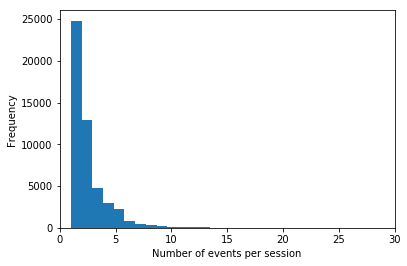

In [19]:
session_events = data.groupby('session_id')['session_id'].count()
ax = session_events.plot.hist(xlim=(0,30), bins=100)
ax.set_xlabel('Number of events per session')
plt.show()

- Most of the sessions ended with 1 or 2 events

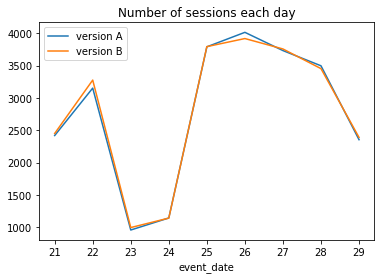

In [20]:
v_sid = data.groupby(['version', 'event_date'])['session_id'].nunique()
ax = v_sid.loc['A'].plot(label = 'version A')
ax = v_sid.loc['B'].plot(label = 'version B')
ax.set_title('Number of sessions each day')
L = plt.legend()

- Traffic sent to each version was almost the same every day.

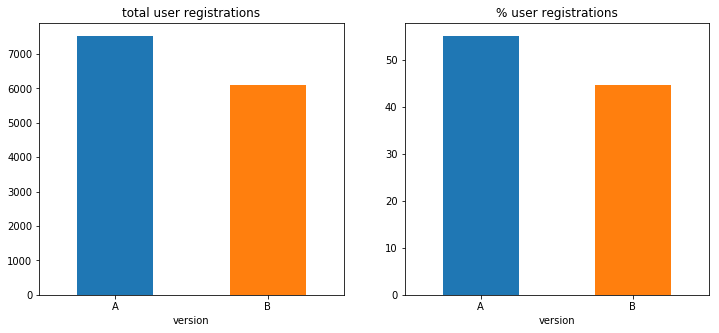

In [21]:
unique_userId = data[data['userId'].notnull()][['userId', 'version', 'server_time']].sort_values(by='server_time', ascending=False).groupby('userId').head(1)

unique_users_ver_df = pd.DataFrame(unique_userId['version'].value_counts())
unique_users_ver_df_total = sum(unique_users_ver_df.version)
unique_users_ver_df['percent'] = unique_users_ver_df.apply(lambda x: (x/unique_users_ver_df_total)*100)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
pd.value_counts(unique_userId['version']).plot(kind="bar", title='total user registrations', rot=0, ax=ax[0])
ax[0].set_xlabel('version')
unique_users_ver_df['percent'].plot(kind="bar", title='% user registrations', rot=0, ax=ax[1])
ax[1].set_xlabel('version')
plt.show()

- Version A has 55% of total registrations

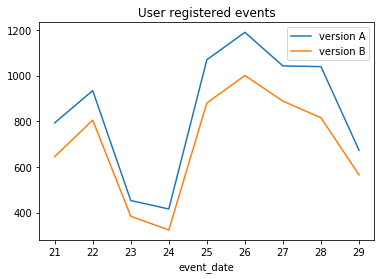

In [22]:
v_uid = data[data['userId'].notnull()][['userId', 'version', 'event_date']].groupby(['version', 'event_date'])['userId'].nunique()
ax = v_uid.loc['A'].plot(label = 'version A')
ax = v_uid.loc['B'].plot(label = 'version B')
ax.set_title('User registered events')
L = plt.legend()
# L.get_texts()[0].set_text('version A')

- version A had more user registered events than version B each day
- 23rd and 24th of june are weekdays. So, there is a dip in amount of traffic coming to the website.

In [23]:
Registration_A = ['signup_type', 'select_occupation', 'signup_main', 'signup_main_student', 'select_org', 'select_grade_student']
Teacher_Registration_A = ['signup_type', 'select_occupation', 'signup_main', 'select_org']
Student_Registration_A = ['signup_type', 'select_occupation', 'signup_main_student', 'select_grade_student']

Registration_B = ['signup_type_select', 'signup_role_picker', 'signup_dob_check', 'signup_account_info', 'signup_select_org']
Teacher_Registration_B = ['signup_type_select', 'signup_role_picker', 'signup_account_info', 'signup_select_org']
Student_Registration_B = ['signup_type_select', 'signup_role_picker', 'signup_dob_check', 'signup_account_info']

version_page_date = data.groupby(['version', 'page', 'event_date']).nunique()

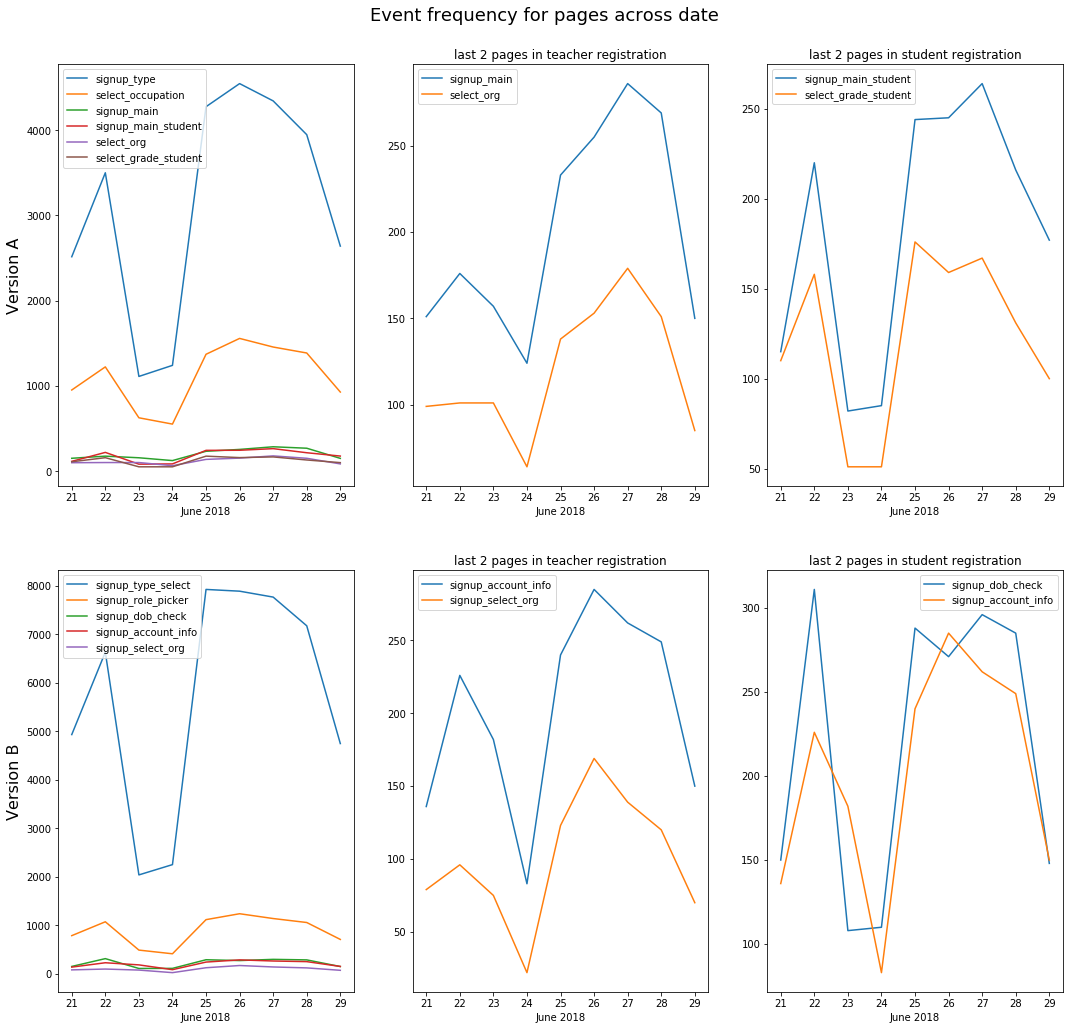

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(18,16))

fig.suptitle('Event frequency for pages across date', fontsize=18)
for i in range(len(Registration_A)):
    ax[0][0].plot(version_page_date.loc['A',Registration_A[i]]['eventId'], label=Registration_A[i])
    ax[0][0].set_xlabel("June 2018")
    ax[0][0].legend(loc='upper left')

for i in range(2, len(Teacher_Registration_A)):
    ax[0][1].plot(version_page_date.loc['A',Teacher_Registration_A[i]]['eventId'], label=Teacher_Registration_A[i])
    ax[0][1].set_title('last 2 pages in teacher registration')
    ax[0][1].set_xlabel("June 2018")
    ax[0][1].legend()
    
for i in range(2, len(Student_Registration_A)):
    ax[0][2].plot(version_page_date.loc['A',Student_Registration_A[i]]['eventId'], label=Student_Registration_A[i])
    ax[0][2].set_title('last 2 pages in student registration')
    ax[0][2].set_xlabel("June 2018")
    ax[0][2].legend()

for i in range(len(Registration_B)):
    ax[1][0].plot(version_page_date.loc['B',Registration_B[i]]['eventId'], label=Registration_B[i])
    ax[1][0].set_xlabel("June 2018")
    ax[1][0].legend(loc='upper left')

for i in range(2, len(Teacher_Registration_B)):
    ax[1][1].plot(version_page_date.loc['B',Teacher_Registration_B[i]]['eventId'], label=Teacher_Registration_B[i])
    ax[1][1].set_title('last 2 pages in teacher registration')
    ax[1][1].set_xlabel("June 2018")
    ax[1][1].legend()
    
for i in range(2, len(Student_Registration_B)):
    ax[1][2].plot(version_page_date.loc['B',Student_Registration_B[i]]['eventId'], label=Student_Registration_B[i])
    ax[1][2].set_title('last 2 pages in student registration')
    ax[1][2].set_xlabel("June 2018")
    ax[1][2].legend()
    
ax[0][0].set_ylabel("Version A", fontsize=16)
ax[1][0].set_ylabel("Version B", fontsize=16)
fig.subplots_adjust(top=0.93)

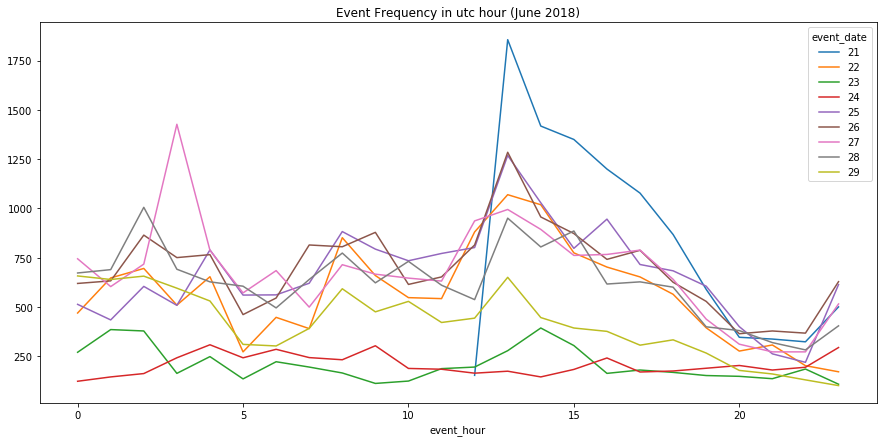

In [25]:
fig, ax = plt.subplots(figsize=(15,7))
data.groupby(['event_date', 'event_hour'])['eventId'].count().unstack(level=0).plot(ax=ax)
ax.set_title('Event Frequency in utc hour (June 2018)')
plt.show()

- The Events peak at 12 utc time and reach the minimum at around 23 utc time. These times correspond to early moring and night respectively for US states where the maximum traffic comes from.

In [26]:
session_time_A = data[data['version']=='A'].sort_values(by='server_time').groupby('session_id')['server_time'].agg(lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds())
session_time_B = data[data['version']=='B'].sort_values(by='server_time').groupby('session_id')['server_time'].agg(lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds())

In [27]:
registered_sessions = data[data['userId'].notnull()][['session_id']]

registered_sessions_A = pd.merge(session_time_A.to_frame(), registered_sessions, left_index=True, right_on='session_id')
registered_sessions_A_mean = registered_sessions_A[registered_sessions_A['server_time'] < 3600]['server_time'].mean()

registered_sessions_B = pd.merge(session_time_B.to_frame(), registered_sessions, left_index=True, right_on='session_id')
registered_sessions_B_mean = registered_sessions_B[registered_sessions_B['server_time'] < 3600]['server_time'].mean()

# df = pd.DataFrame({'version':['A', 'B'], 'session_time':[registered_sessions_B_mean, registered_sessions_B_mean]})
# ax = df.plot.bar(x='version', y='session_time', rot=0)
# ax.set_title('registered session average time per version (secs)')

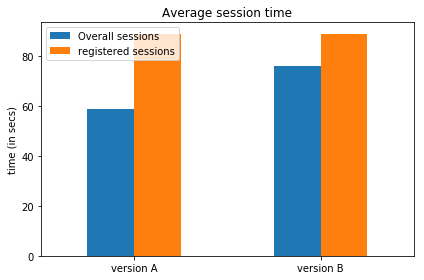

In [28]:
session_avg = [(session_time_A[session_time_A < 3600]).mean(), (session_time_B[session_time_B < 3600]).mean()]
registered_session_avg = [registered_sessions_B_mean, registered_sessions_B_mean]
index = ['version A', 'version B']
df = pd.DataFrame({'Overall sessions': session_avg, 'registered sessions': registered_session_avg}, index=index)
ax = df.plot.bar(rot=0)
ax.set_title('Average session time')
ax.set_ylabel('time (in secs)')
ax.legend(loc='upper left')
plt.tight_layout()

<p>Here, we can see that the average time spent on pages for registered sessions has increased in both versions compared to the time for overall sessions. This might be due to the fact that it takes more time to go through all pages and register than leaving the site halfway un-registered.</p>

#### <u>Assumption</u>
- I have taken session time as time between first and last event in a session.
- In some cases, users might have left the site open and unattended for some time. These, being the outliers are less in number and greatly affect the session time. I have excluded those sessions spaning more than an hour for the above calculation.

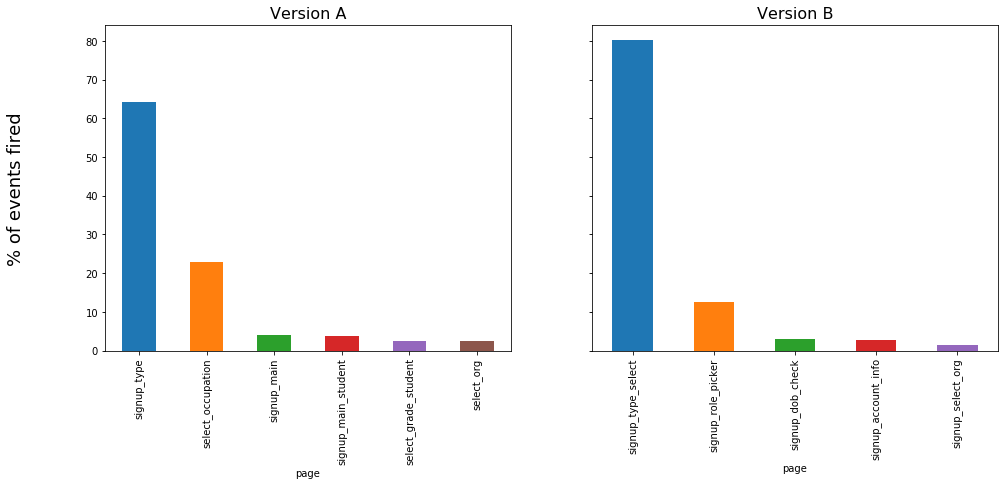

In [29]:
page_freq_A = data[data['version'] == 'A']['page'].value_counts().to_frame()
total_events_A = sum(data[data['version'] == 'A']['page'].value_counts())
page_freq_A['percent'] = page_freq_A.page.apply(lambda x: (x/total_events_A)*100)
# page_freq_A['percent']

page_freq_B = data[data['version'] == 'B']['page'].value_counts().to_frame()
total_events_B = data[data['version'] == 'B']['eventId'].count()
page_freq_B['percent'] = page_freq_B.page.apply(lambda x: (x/total_events_B)*100)
# page_freq_B['percent'].plot.bar()

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
page_freq_A['percent'].plot.bar(ax=ax[0])
ax[0].set_xlabel('page')
ax[0].set_title('Version A', fontsize=16)
page_freq_B['percent'].plot.bar(ax=ax[1])
ax[1].set_title('Version B', fontsize=16)
ax[1].set_xlabel('page')
fig.text(0.04, 0.5, '% of events fired', va='center', rotation='vertical', fontsize=18)
plt.show()

- The number of events fired reduced as the user moved from first signup page to the rest.
- There's a huge decrease in events from first to second page in both versions.
- The same can be seen between second and third page as well.
- Almost same number of events were fired for the rest of the pages. So, we can roughly say that there's a good chance that user might have finished the whole registration process once he reached the third page.

Though events are not an exact measure of registrations, it is a measure of user interaction with the website. Higher the interaction, higher the chance of signing up.

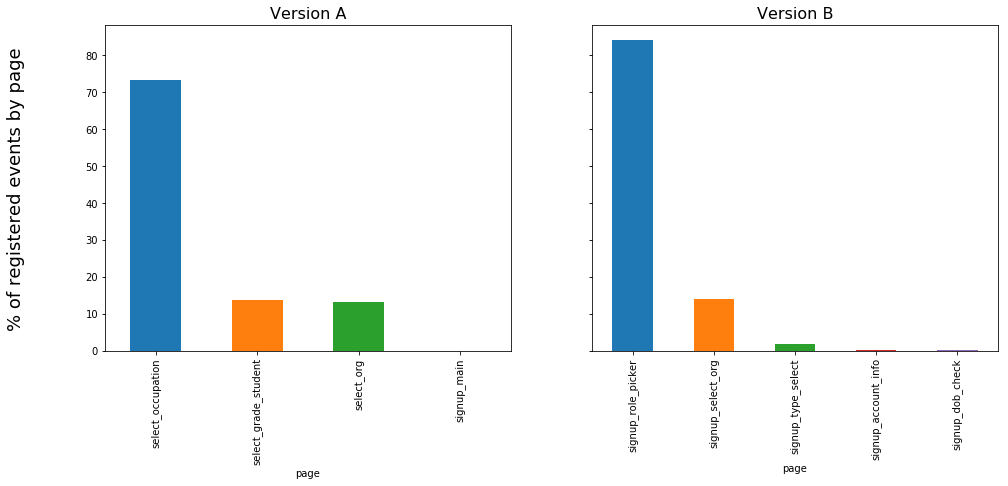

In [30]:
r_page_freq_A = data[(data['version'] == 'A') & (data.userId.notnull())]['page'].value_counts().to_frame()
r_total_events_A = sum(r_page_freq_A.page)
r_page_freq_A['percent'] = r_page_freq_A.page.apply(lambda x: (x/r_total_events_A)*100)


r_page_freq_B = data[(data['version'] == 'B') & (data.userId.notnull())]['page'].value_counts().to_frame()
r_total_events_B = sum(r_page_freq_B.page)
r_page_freq_B['percent'] = r_page_freq_B.page.apply(lambda x: (x/r_total_events_B)*100)
# page_freq_B['percent'].plot.bar()

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
r_page_freq_A['percent'].plot.bar(ax=ax[0])
ax[0].set_xlabel('page')
ax[0].set_title('Version A', fontsize=16)
r_page_freq_B['percent'].plot.bar(ax=ax[1])
ax[1].set_title('Version B', fontsize=16)
ax[1].set_xlabel('page')
fig.text(0.04, 0.5, '% of registered events by page', va='center', rotation='vertical', fontsize=18)
plt.show()

Most of the user's registered in the page to <b>select their role (teacher or student)</b>

## Conclusion
<ul>
    <b style='font-size: 16px'><i>Version A performed better than version B</i></b>
    <li> Version A (7554) had higher number of registrations compared to version B (6245).</li>
    <li> Version A had more User Registered events than version B every day. So, this gives us a consistent conclusion that version A has performed better than version B on every single day. </li>
</ul>

<ul>
    <b style='font-size: 16px'><i>Huge drop in users from first to second page</i></b>
    <li>There are lot of sessions with just one event. The user's opened the signup page, looked at it and left the page without interacting any further.</li>
    <li>There is a significant drop in number of user's reaching the second page and third page. The user's most likely finished the registration or reached the final page once they moved past the second page. </li>
</ul>

<ul>
    <b style='font-size: 16px'><i>Most registrations are done in second page of both versions</i></b>
    <li>73% and 84% of total registrations in version A and B respectively were done in second page of the signup process.</li>
    <li>We can have more successful signups if we retain user's in second page. </li>
</ul>

<ul>
<b style='font-size: 16px'><i>Site traffic</i></b>
    <li>There is a huge dip in traffic coming to the website on weekends. This is expected out of products related to education.</li>
    <li>Traffic peaks at 12 utc and is minimum at 23 hour utc time corresponding to US morning and night. </li>
</ul>